Author: Tuwe Löfström (tuwe.lofstrom@ju.se)  
Copyright 2023 Tuwe Löfström  
License: BSD 3 clause

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from calibrated_explanations import CalibratedExplainer, VennAbers, __version__
from lime.lime_tabular import LimeTabularExplainer

print(f"calibrated_explanations {__version__}")

calibrated_explanations v0.3.3


In [3]:
sat = fetch_openml('satimage', version=1, parser='auto')
print(sat.DESCR)
sat.frame.head()
print(len(sat.data))

**Author**: Ashwin Srinivasan, Department of Statistics and Data Modeling, University of Strathclyde  
**Source**: [UCI](https://archive.ics.uci.edu/ml/datasets/Statlog+(Landsat+Satellite)) - 1993  
**Please cite**: [UCI](https://archive.ics.uci.edu/ml/citation_policy.html)  

The database consists of the multi-spectral values of pixels in 3x3 neighbourhoods in a satellite image, and the classification associated with the central pixel in each neighbourhood. The aim is to predict this classification, given the multi-spectral values. In the sample database, the class of a pixel is coded as a number. 

One frame of Landsat MSS imagery consists of four digital images of the same scene in different spectral bands. Two of these are in the visible region (corresponding approximately to green and red regions of the visible spectrum) and two are in the (near) infra-red. Each pixel is a 8-bit binary word, with 0 corresponding to black and 255 to white. The spatial resolution of a pixel is about

Divide data and use 3 instances from each class as test instances.

In [4]:
num_to_test = 18
target = 'class'
X, y = sat.frame.drop(target, axis=1), LabelEncoder().fit_transform(sat.frame[target])
no_of_classes = len(np.unique(y))
no_of_features = X.shape[1]
no_of_instances = X.shape[0]

test_idx = []
idx = list(range(no_of_instances))
for i in range(no_of_classes):
    test_idx.append(np.where(y == i)[0][0:int(num_to_test/no_of_classes)])
test_index = np.array(test_idx).flatten()
# Select num_to_test/2 from top and num_to_test/2 from bottom of list of instances
train_index = np.setdiff1d(np.array(range(no_of_instances)), test_index)   
trainCalX, testX = X.values[train_index,:], X.values[test_index,:]
trainCalY, testY = y[train_index], y[test_index]
trainX, calX, trainY, calY = train_test_split(trainCalX, trainCalY, test_size=0.33,random_state=42, stratify=trainCalY)
print(testY)
# print(categorical_features)

[0 0 0 1 1 1 2 2 2 3 3 3 4 4 4 5 5 5]


Train the predictor.

In [5]:
model = RandomForestClassifier(n_estimators=100)
model_name = 'RF' 
model.fit(trainX,trainY)  

RandomForestClassifier()

Examplify how VennAbers can provide probabilities and uncertainty intervals for multi-class. Note that VennAbers output the probabilities and uncertainty intervals for all classes together with the predicted classes. It is obvious from these examples that class 3 and 5 are hardest.

In [6]:
va = VennAbers(model.predict_proba(calX), calY, model)
va_proba, low, high, predicted_classes = va.predict_proba(testX, output_interval=True)
print(*zip([low[i,c] for i,c in enumerate(predicted_classes)], [va_proba[i,c] for i,c in enumerate(predicted_classes)], [high[i,c] for i,c in enumerate(predicted_classes)], testY, predicted_classes),sep='\n')  

(0.9957627058029175, 0.9957805847068542, 1.0, 0, 0)
(0.9957627058029175, 0.9957805847068542, 1.0, 0, 0)
(0.9926199316978455, 0.9926470640634275, 0.9963099360466003, 0, 0)
(0.9953051805496216, 0.99532711888278, 1.0, 1, 1)
(0.96875, 0.9696969696969697, 1.0, 1, 1)
(0.9953051805496216, 0.99532711888278, 1.0, 1, 1)
(0.924369752407074, 0.9252010766531791, 0.9354838728904724, 2, 2)
(0.9444444179534912, 0.946646315896366, 0.9857142567634583, 2, 2)
(0.9444444179534912, 0.946646315896366, 0.9857142567634583, 2, 2)
(0.9240506291389465, 0.9249999970570207, 0.9367088675498962, 3, 5)
(0.6399999856948853, 0.6511205239836668, 0.671875, 3, 5)
(0.692307710647583, 0.7142857300991915, 0.7692307829856873, 3, 3)
(0.9375, 0.9384615384615385, 0.953125, 4, 4)
(0.9811320900917053, 0.9814814955650208, 1.0, 4, 4)
(0.9915966391563416, 0.9916666671592328, 1.0, 4, 4)
(0.739130437374115, 0.7582417588487693, 0.8181818127632141, 5, 3)
(0.9950000047683716, 0.9950248803429337, 1.0, 5, 5)
(0.65625, 0.6625766910649318, 0.6

Create a `CallibratedExplainer` from the model and the calibration data. The interface for creating multi-class explanations is identical to binary classification. The explanations provided will indicate the probabilities and uncertainties for the most likely class vs all other classes. 

DISCLAIMER: Currently, the explanations does not support explanations and uncertainties for each possible class, it only explains the class predicted after calibration (which might be different from the prediction made by the underlying model if the calibration alters the probabilities in favor of an alternative class).

In [7]:
ce = CalibratedExplainer(model, calX, calY, \
                    feature_names=sat.frame.columns)
display(ce)

CalibratedExplainer:
	                mode=classification
	                mondrian=False
	                discretizer=<class 'NoneType'>
	                model=RandomForestClassifier()
	                init_time=0.07164192199707031
	                latest_explanation is None
	                

Explain the test set using factual explanations.

In [8]:
factual_explanation = ce.explain_factual(testX)

Plot the explanations with and without uncertainty.

c:\Users\loftuw\AppData\Local\anaconda3\envs\ce\lib\site-packages\calibrated_explanations\_explanations.py:955: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(10,num_to_show*.5+2))


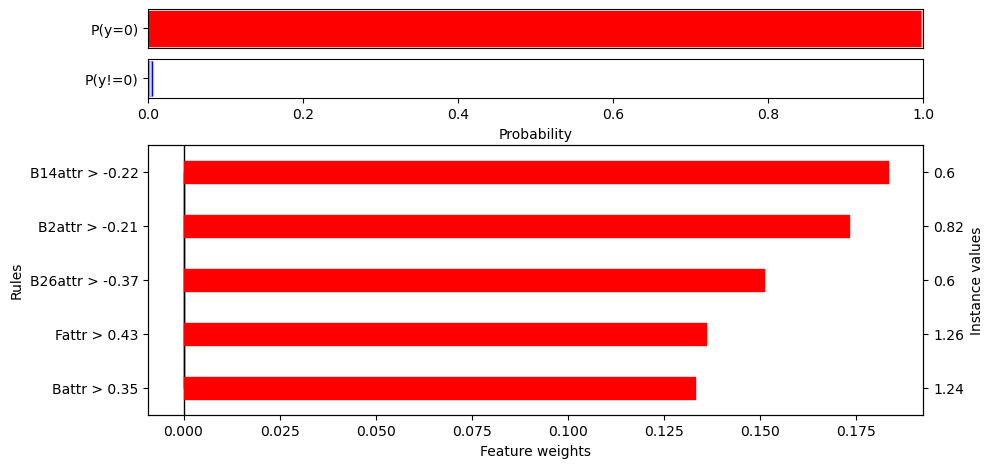

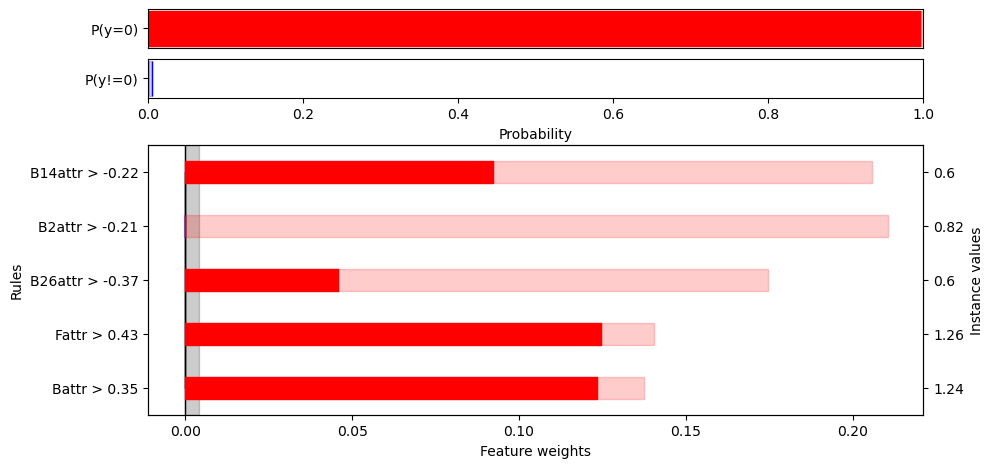

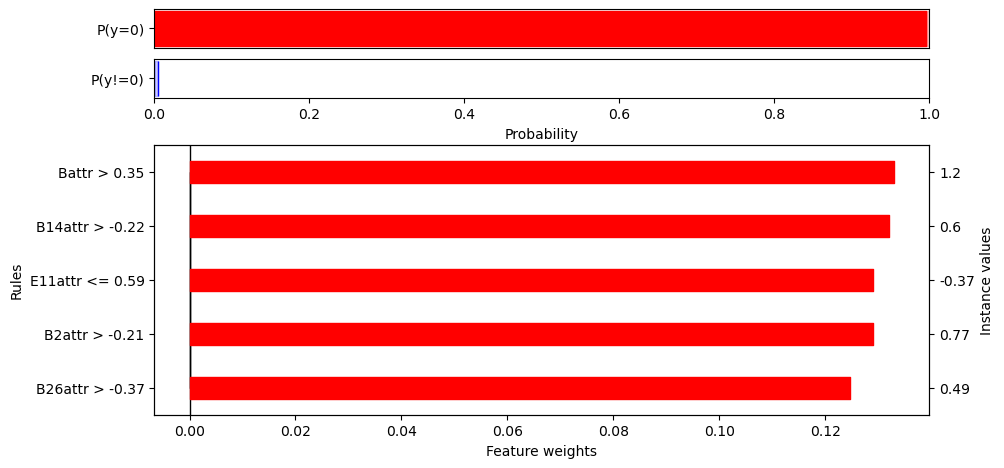

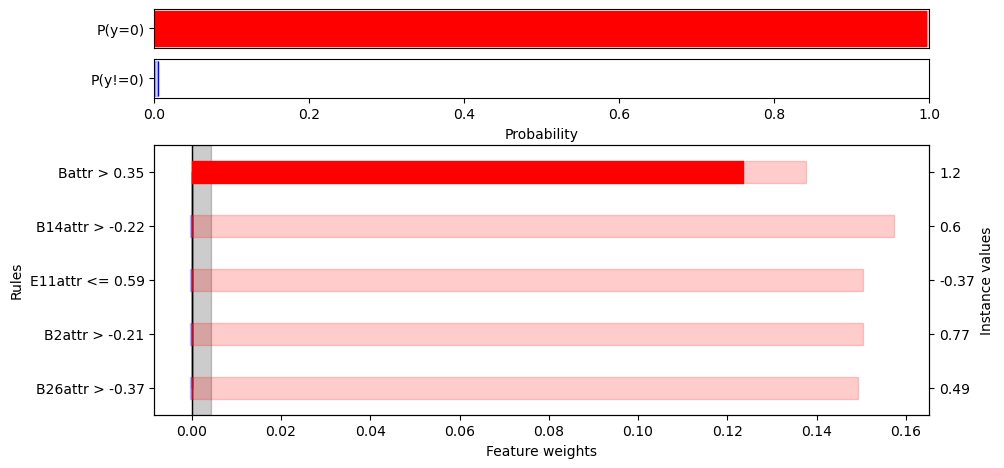

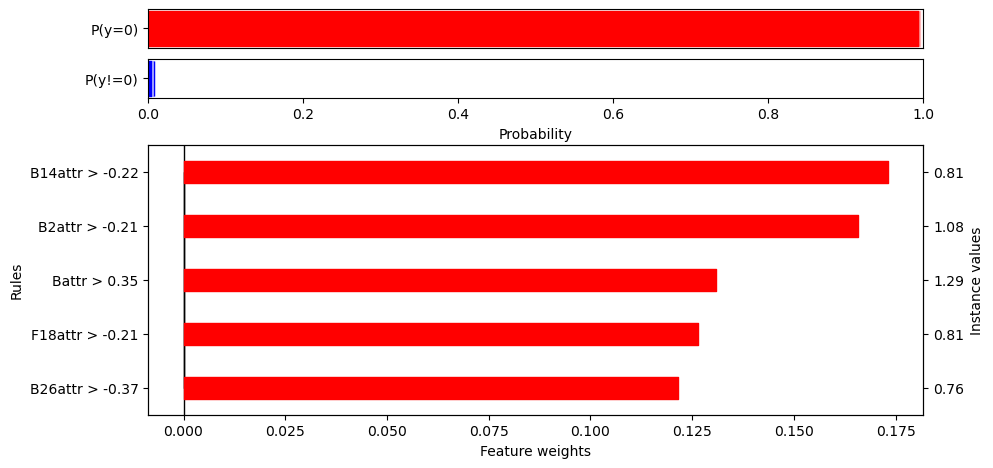

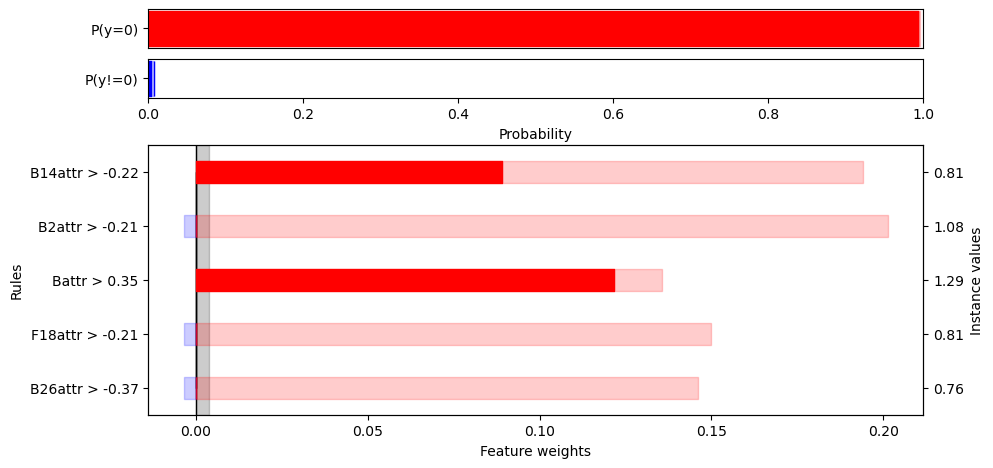

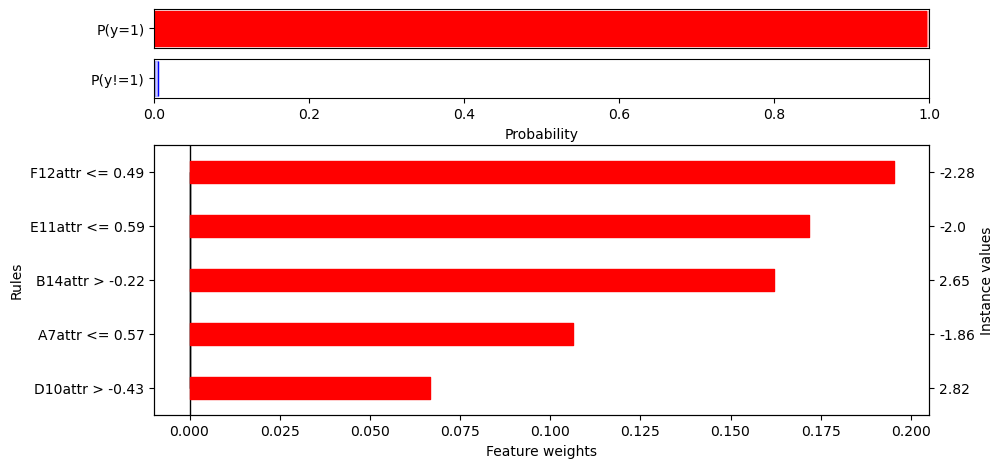

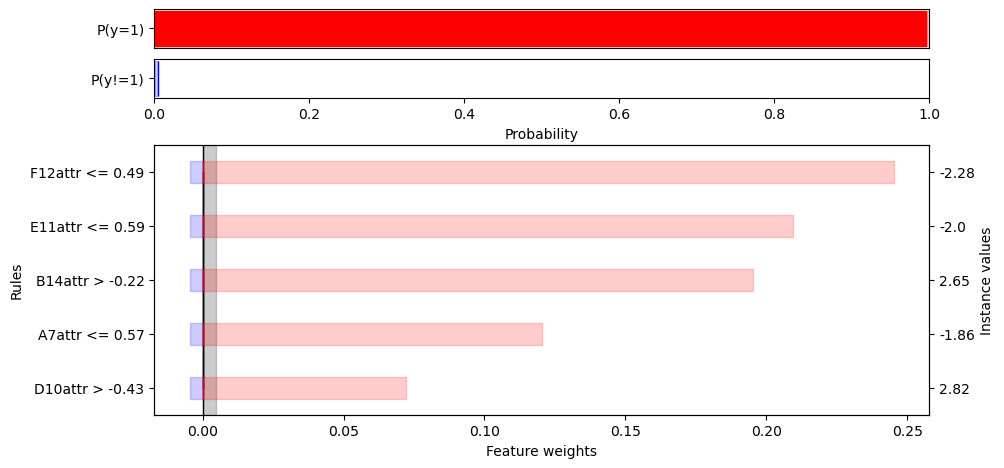

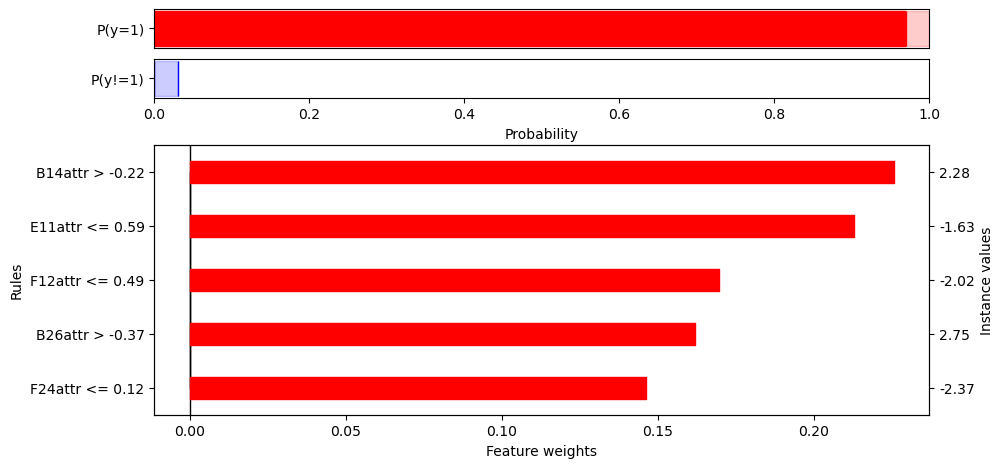

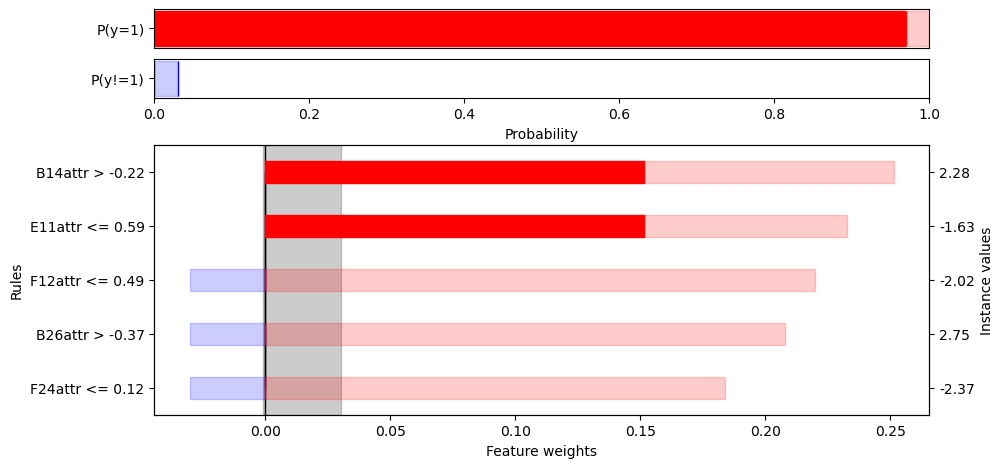

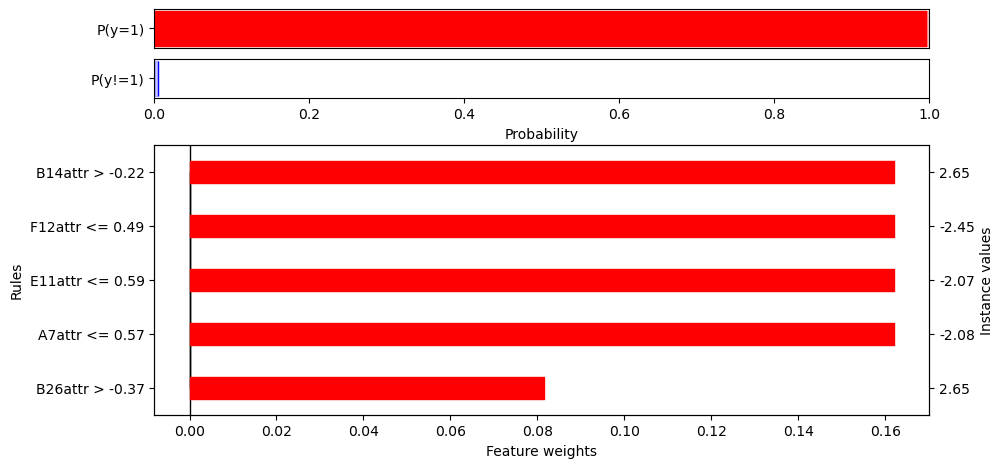

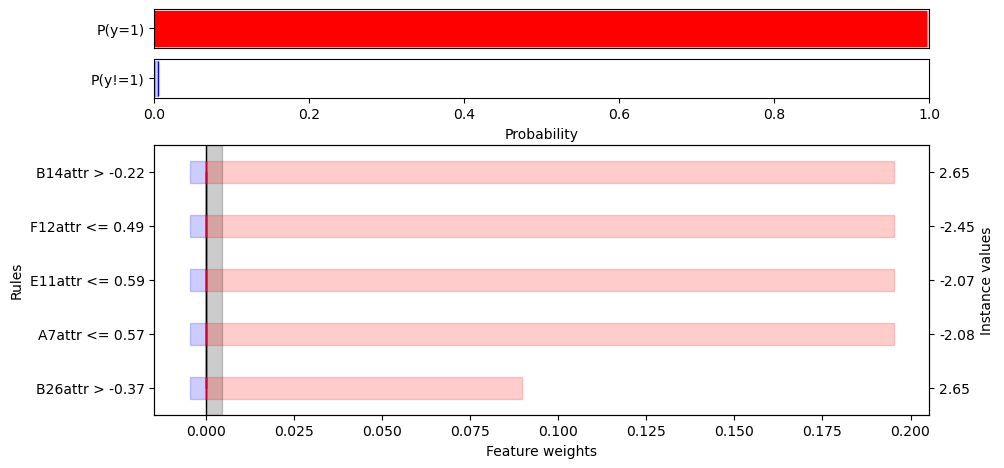

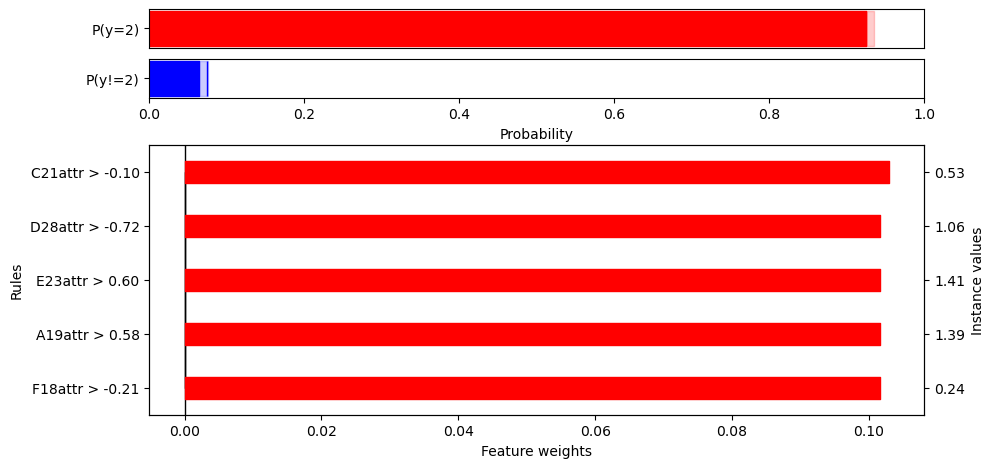

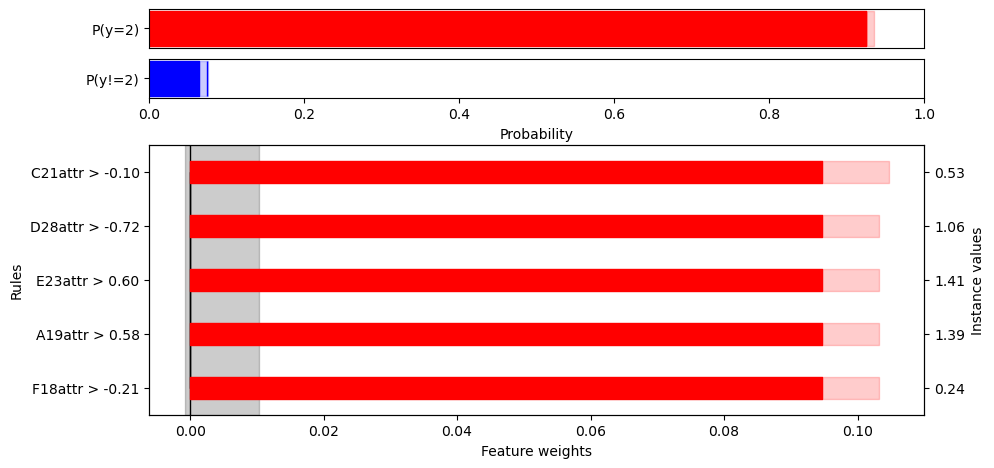

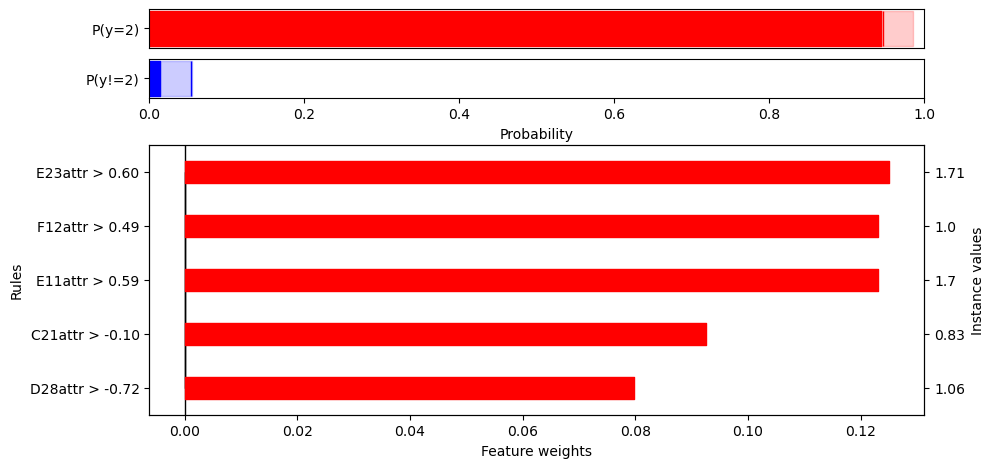

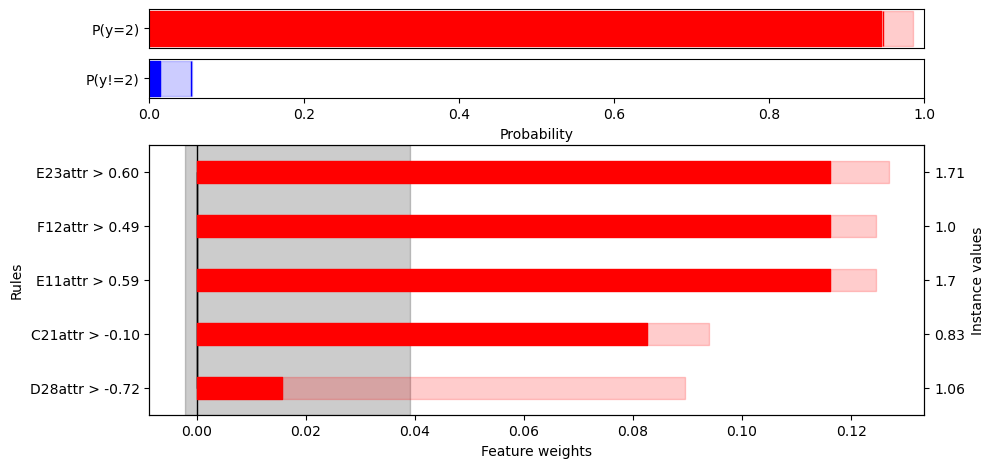

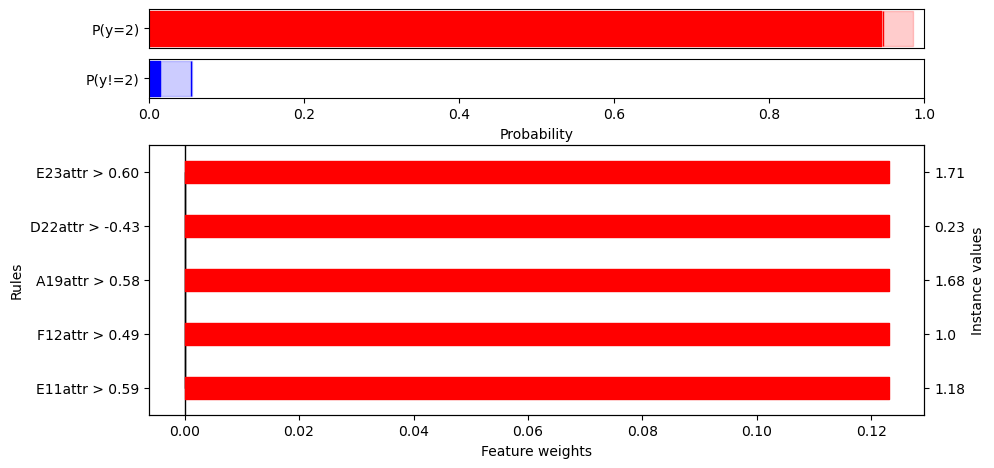

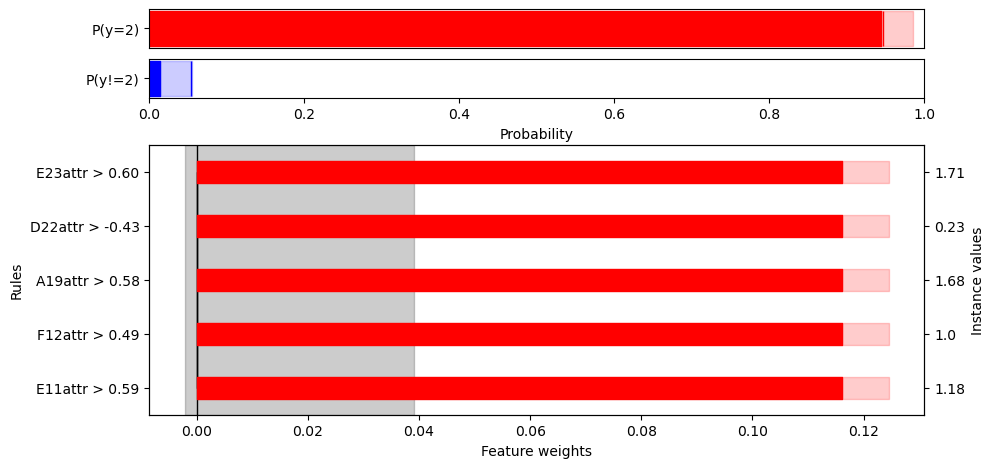

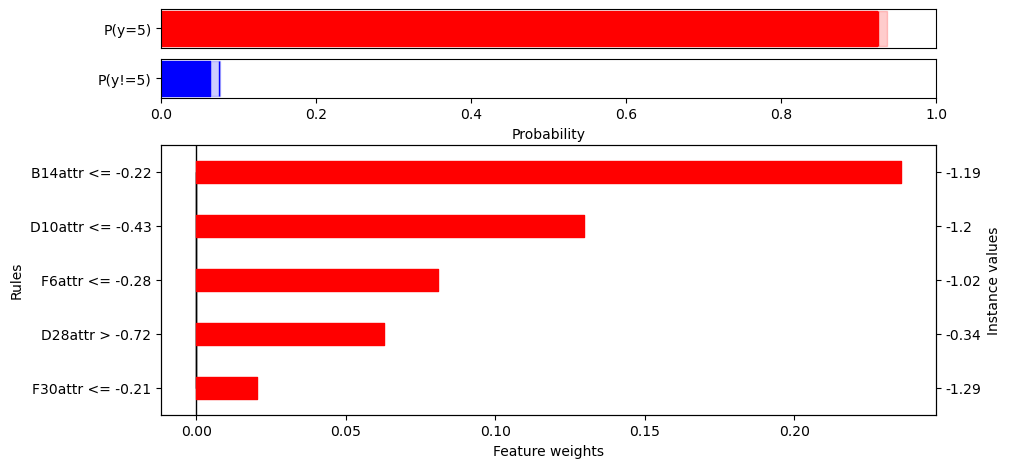

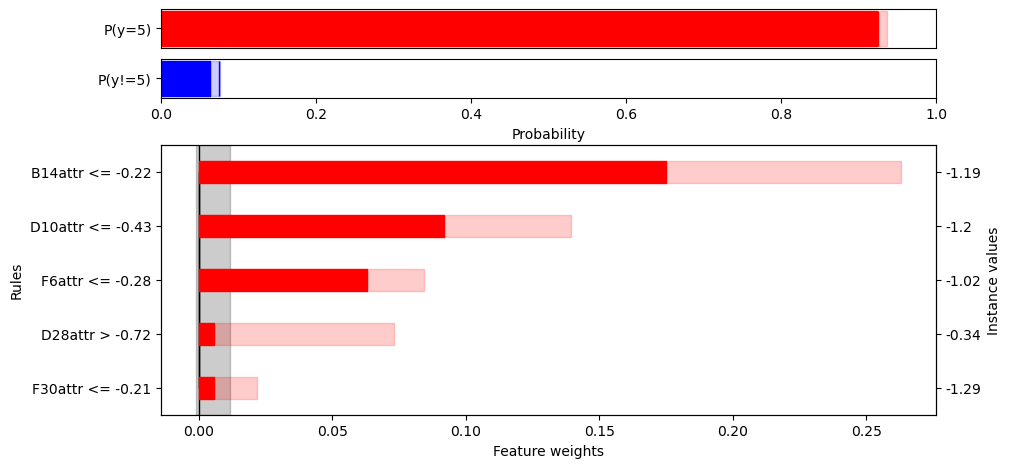

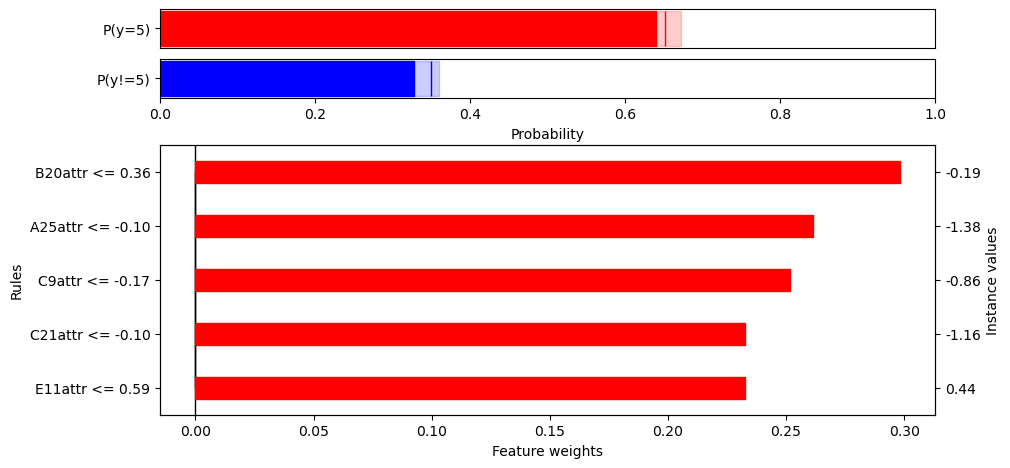

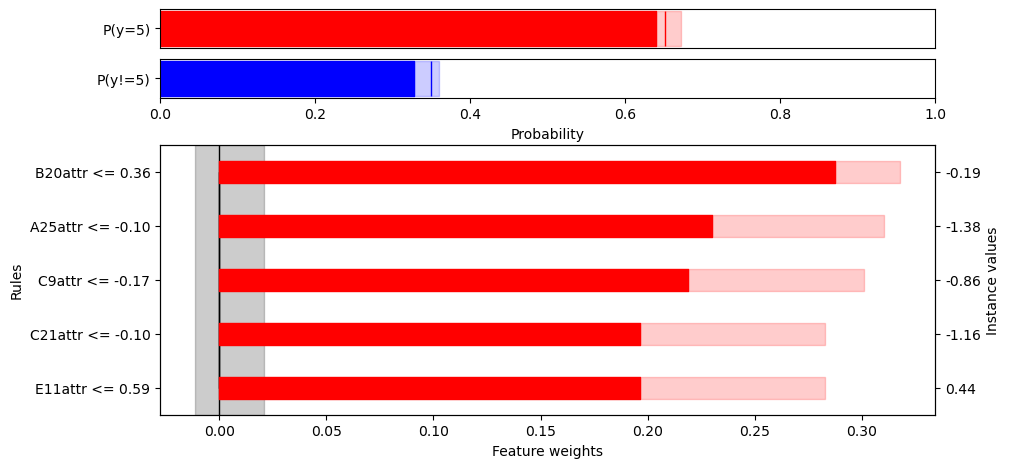

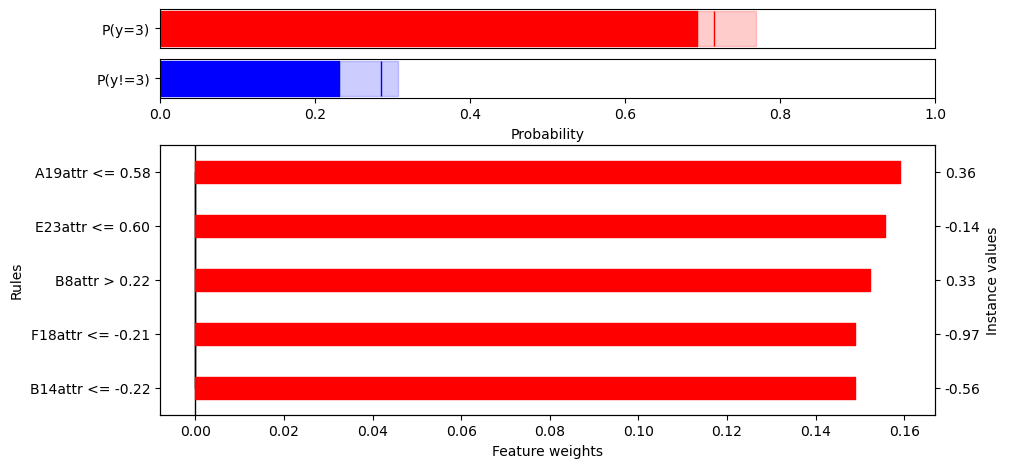

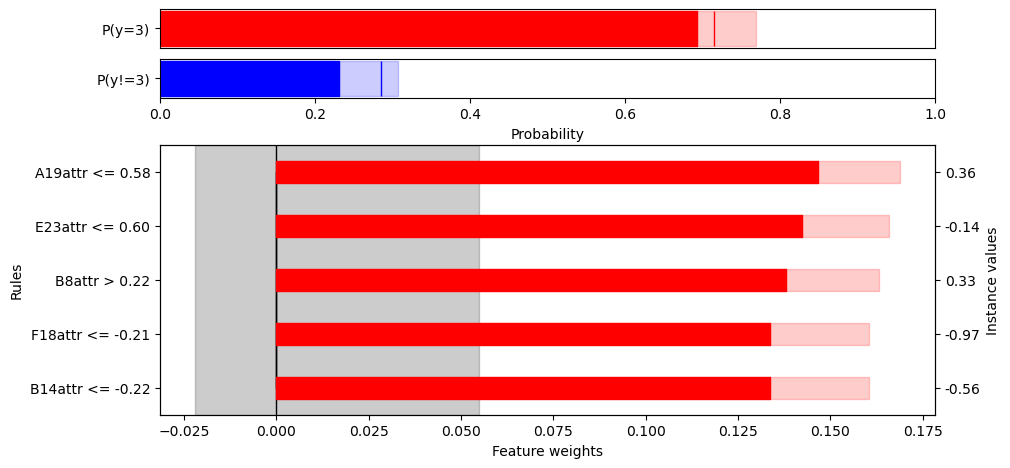

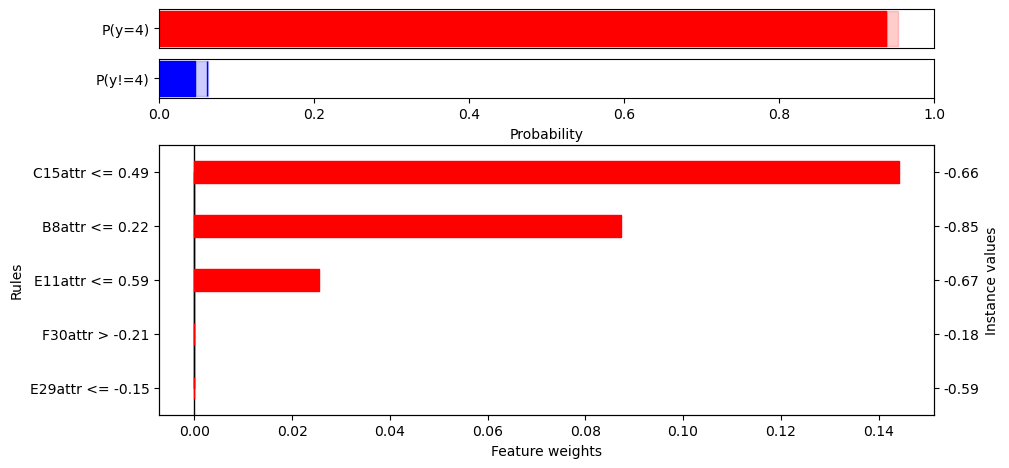

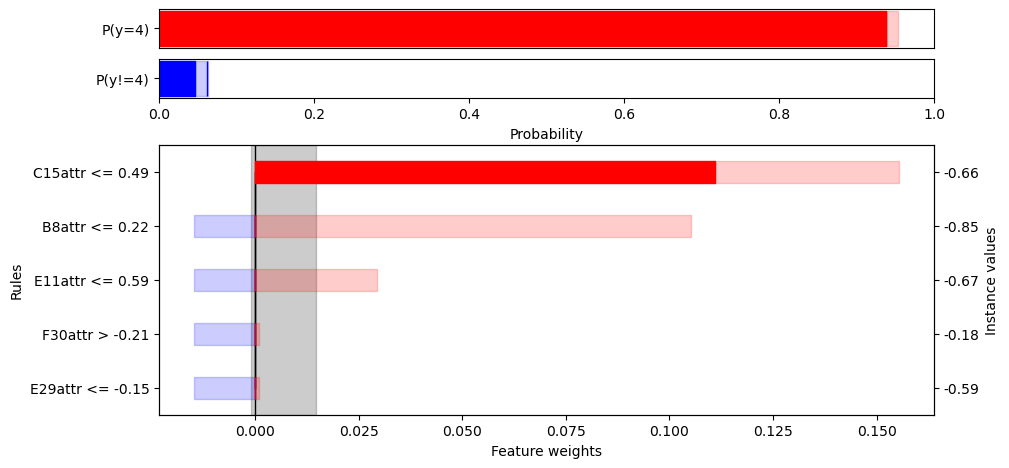

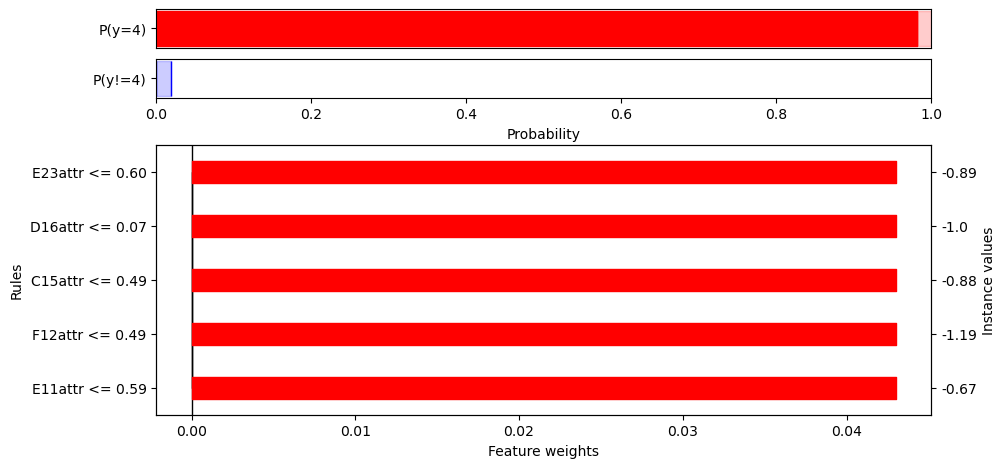

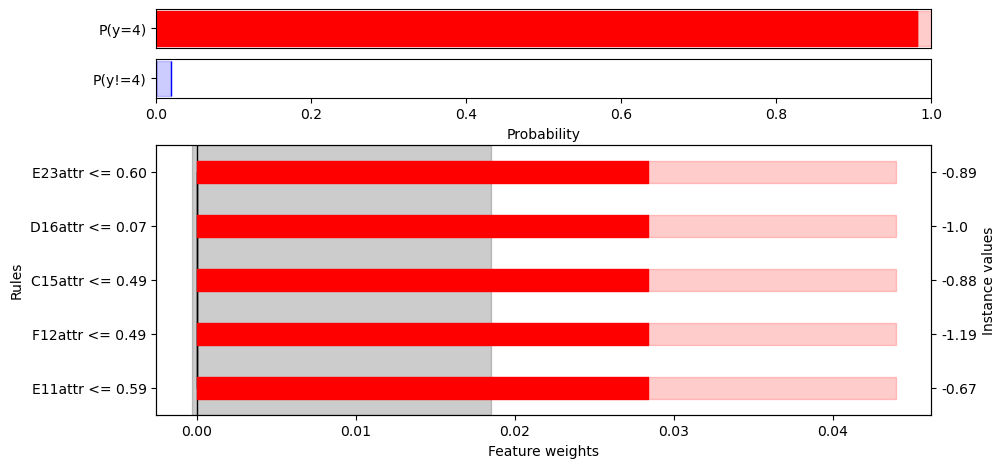

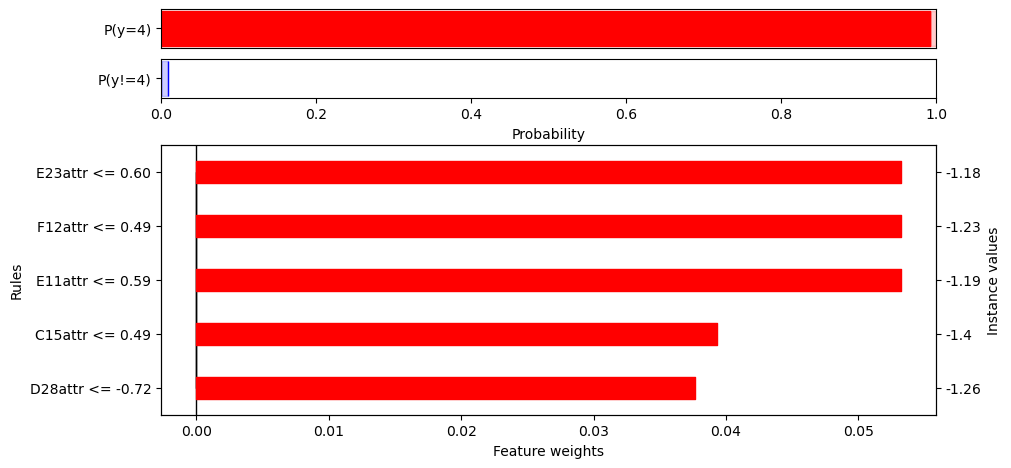

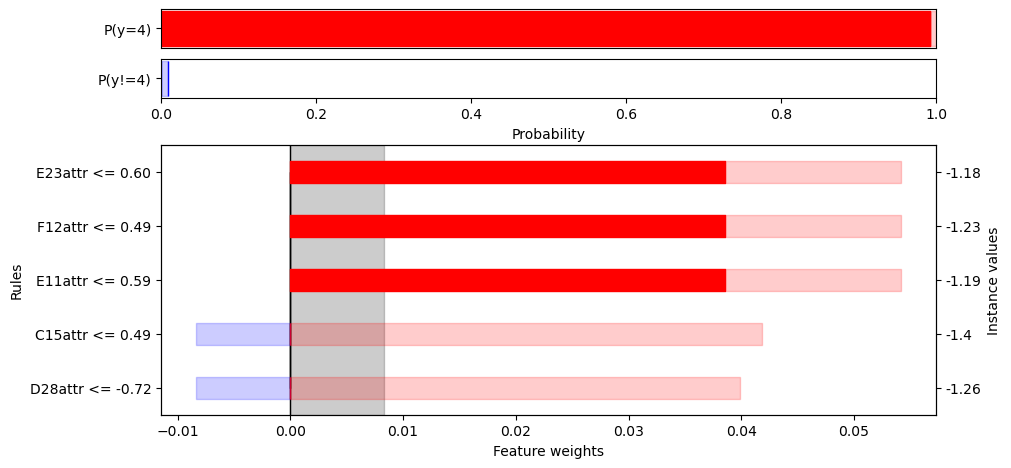

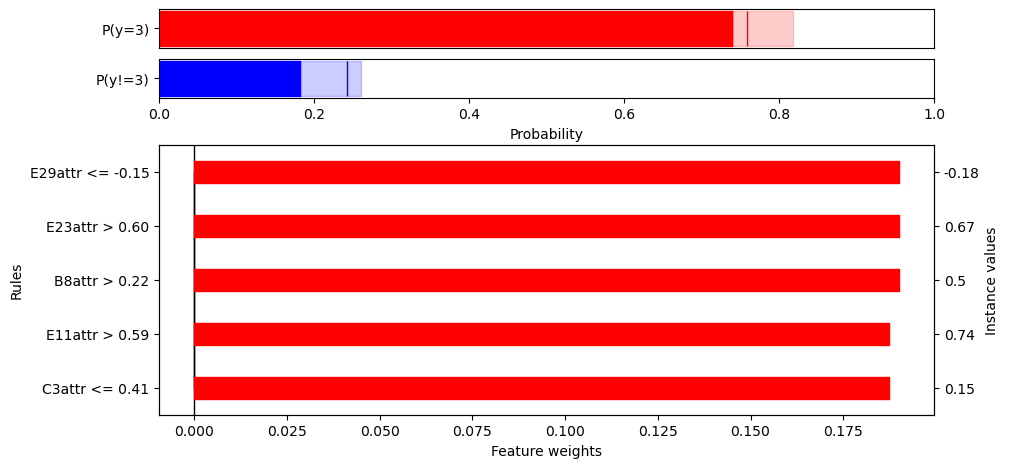

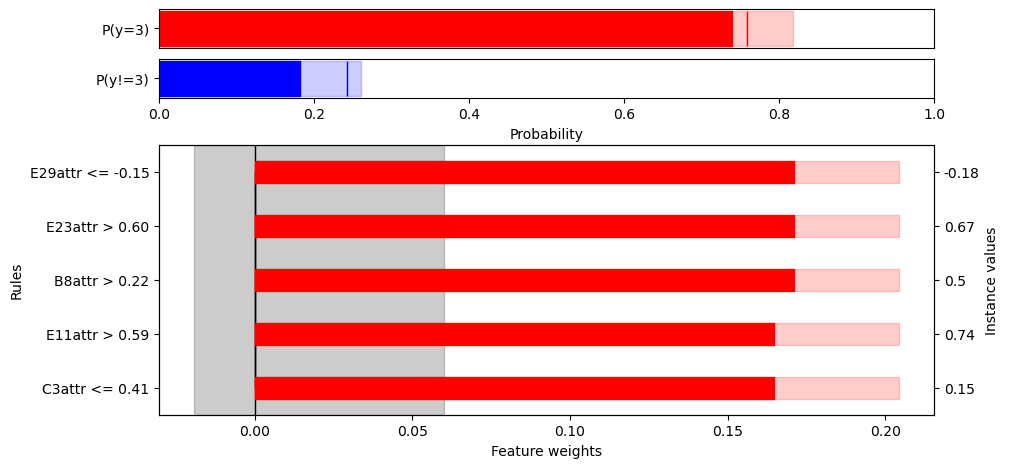

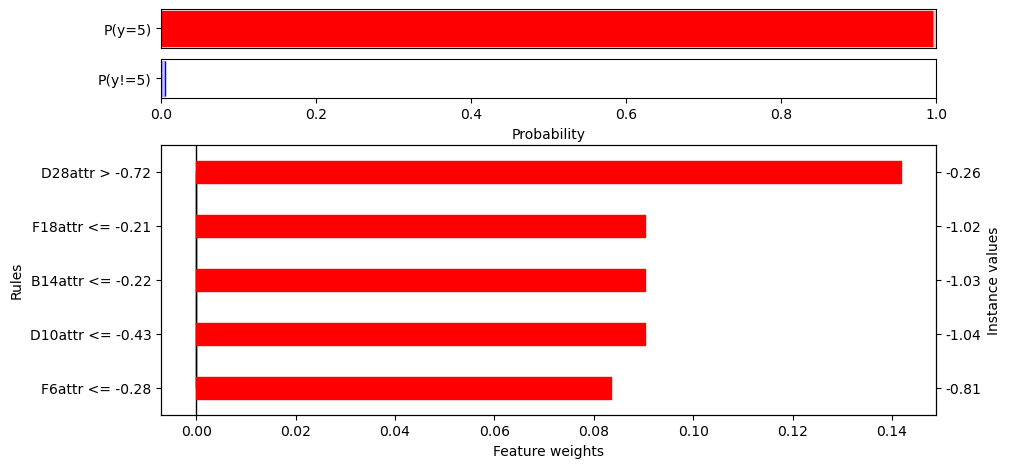

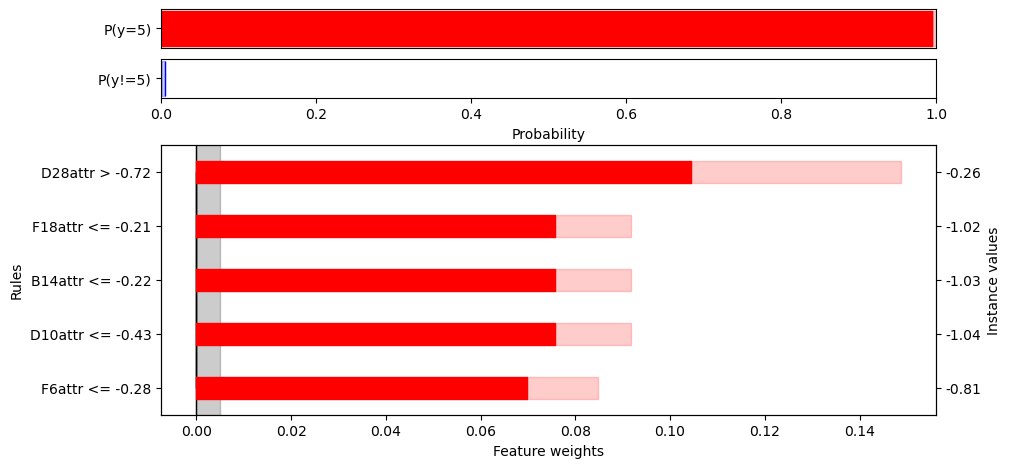

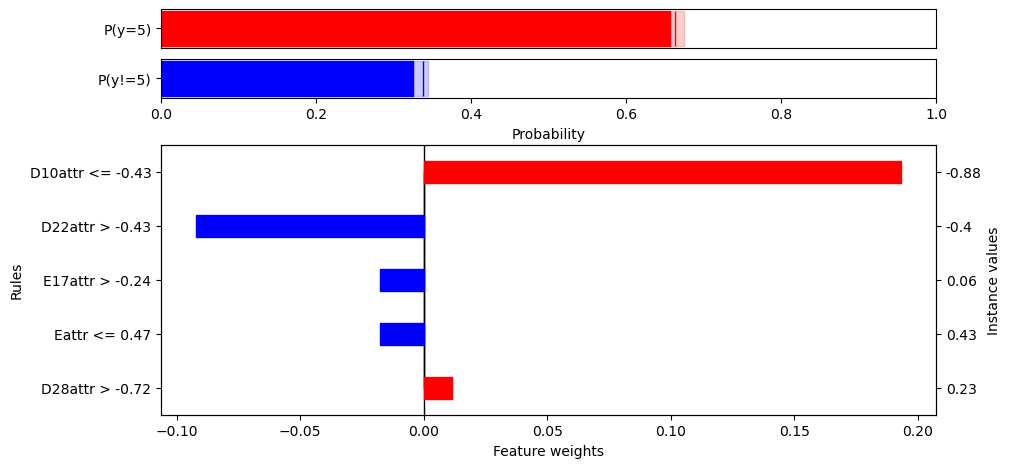

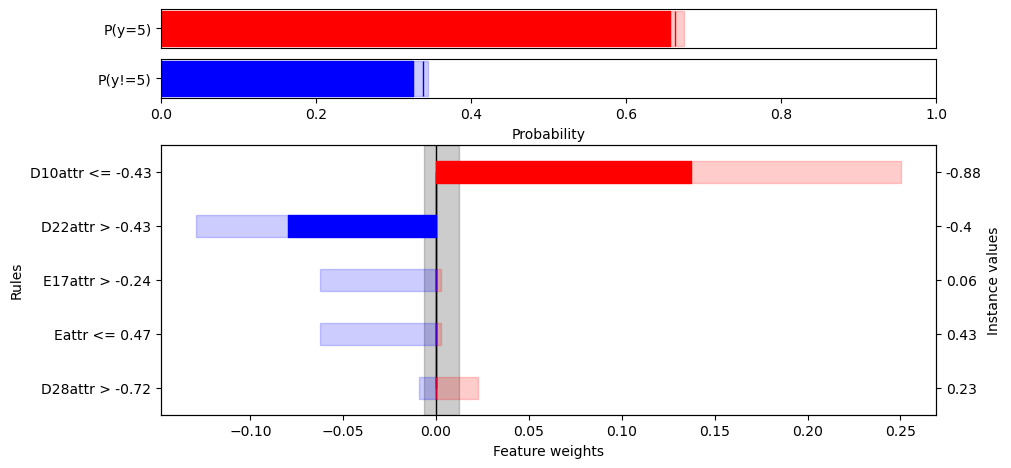

In [9]:
for i in range(num_to_test):
    factual_explanation.plot_explanation(i, n_features_to_show=5)
    factual_explanation.plot_explanation(i, uncertainty=True, n_features_to_show=5)

Add conjunctions to one of the more difficult instances (actually belonging to class 5 but incorrectly predicted as class 3). This is a somewhat costly operation, as combinations of indvidual conditions are explored. Conjunctions with up to three conditons can be created. As with atomic conditions, rules are shown in order of importance, based on the absolute feature weight.   

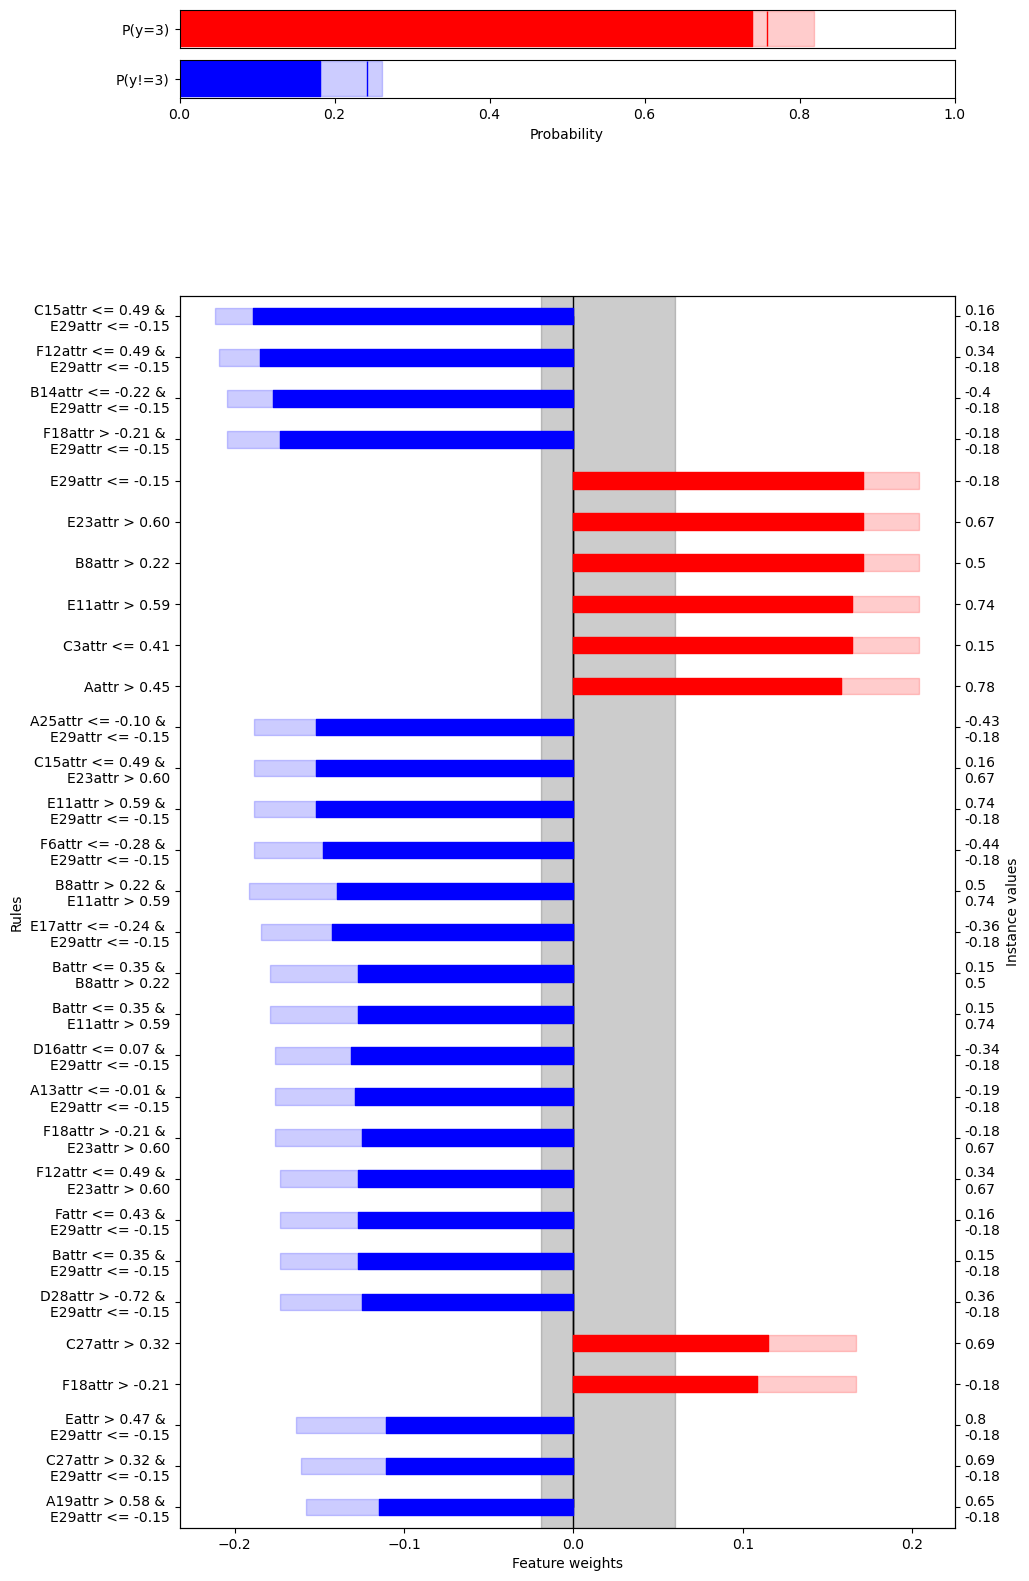

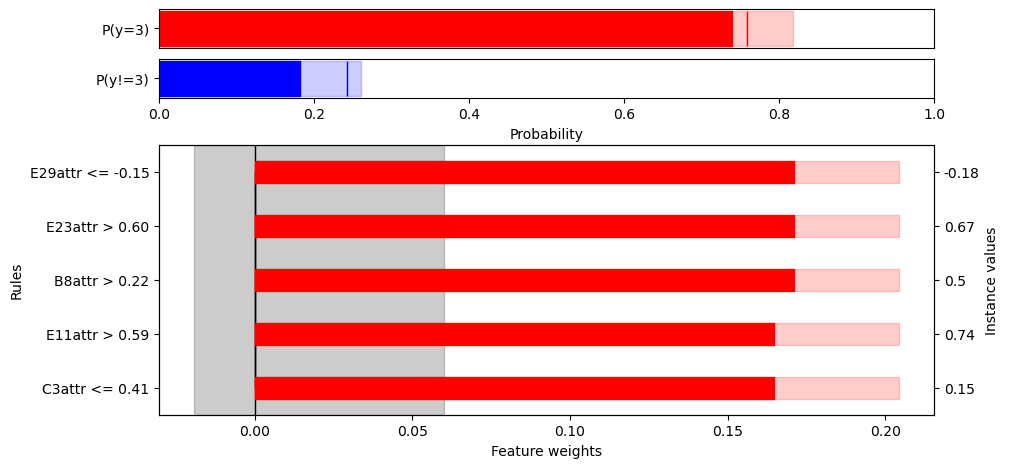

In [10]:
factual_15 = factual_explanation.get_explanation(15)
factual_15.add_conjunctions(max_rule_size=2).plot_explanation(uncertainty=True, n_features_to_show=30)
factual_15.remove_conjunctions().plot_explanation(uncertainty=True, n_features_to_show=5)

Another instance, being correctly predicted but with some uncertainty as to the prediction is shown with conjunctions below.

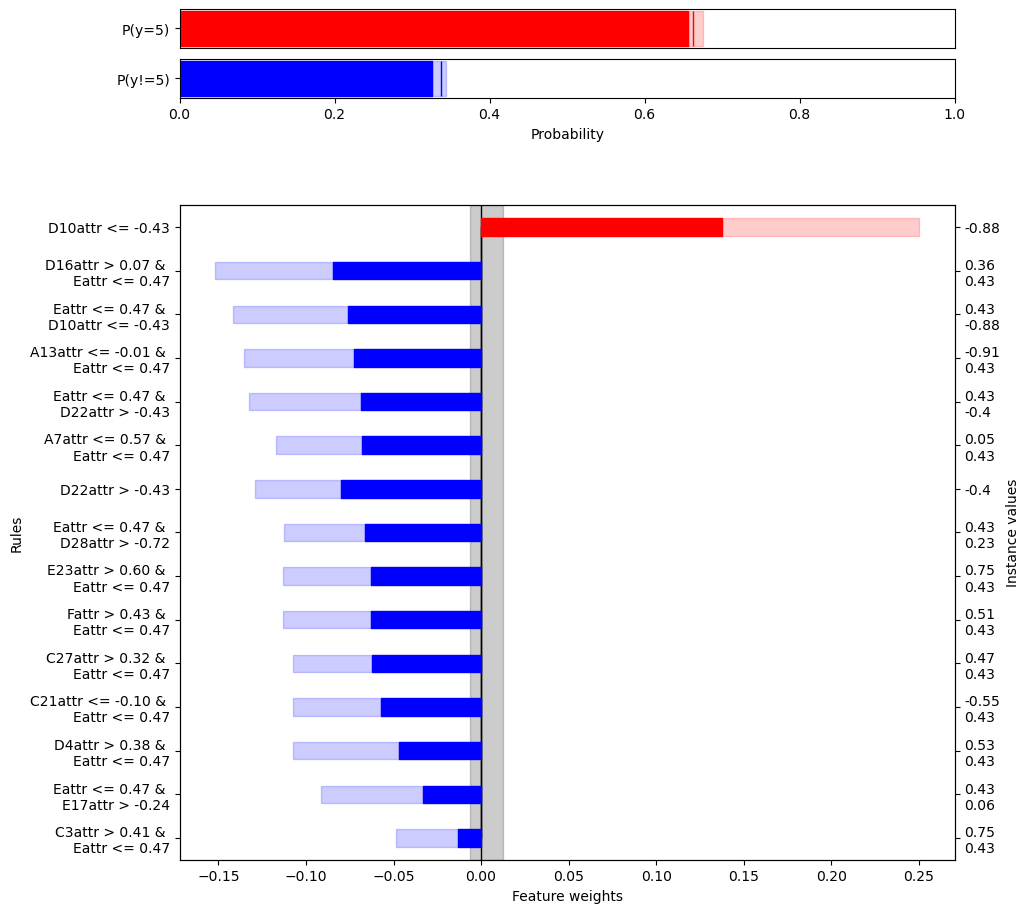

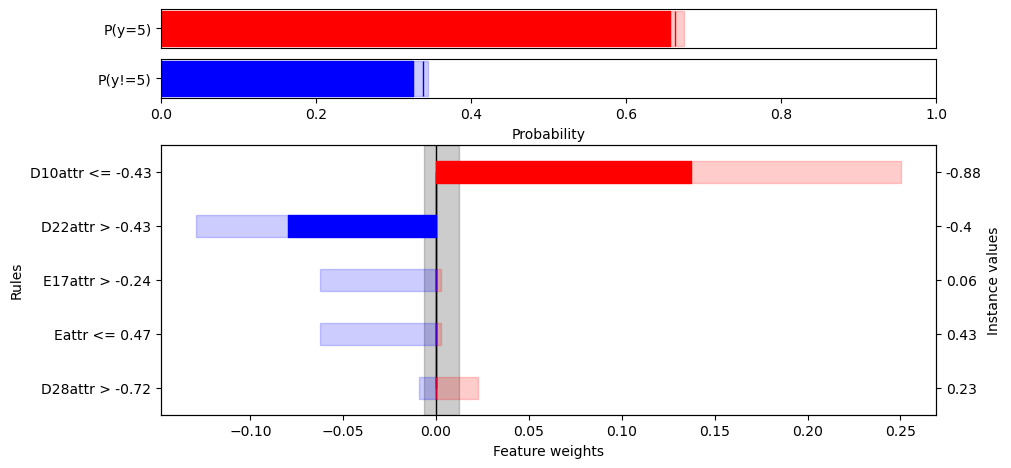

In [11]:
factual_17 = factual_explanation.get_explanation(17)
factual_17.add_conjunctions(max_rule_size=2).plot_explanation(uncertainty=True, n_features_to_show=15)
factual_17.remove_conjunctions().plot_explanation(uncertainty=True, n_features_to_show=5)

Explain the test set using counterfactual explanations.

In [12]:
counterfactual_explanation = ce.explain_counterfactual(testX)

Plot the counterfactual explanations. 

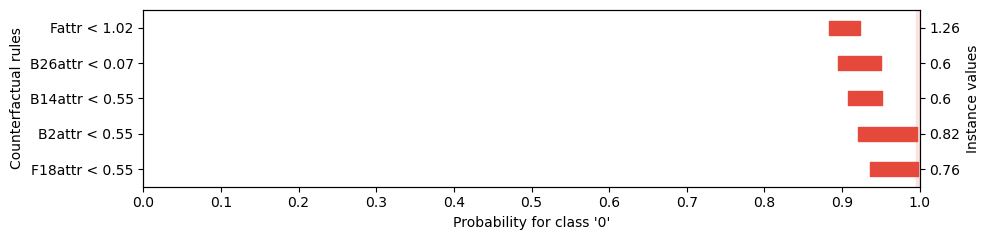

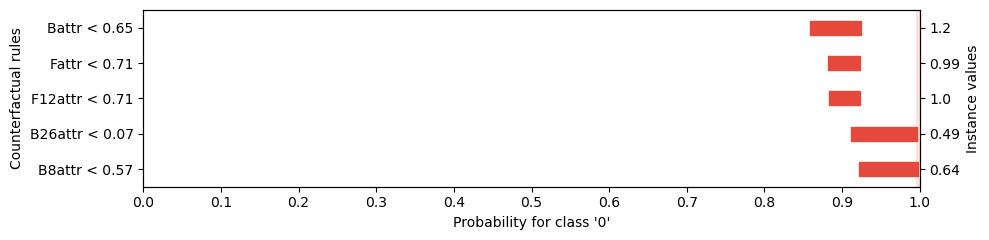

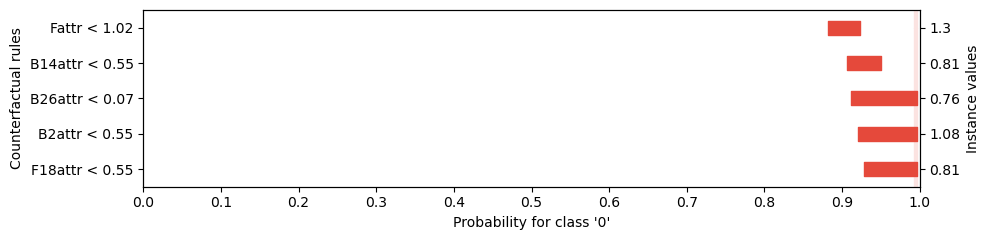

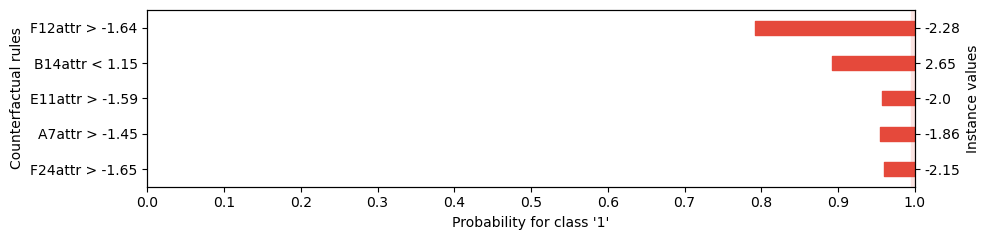

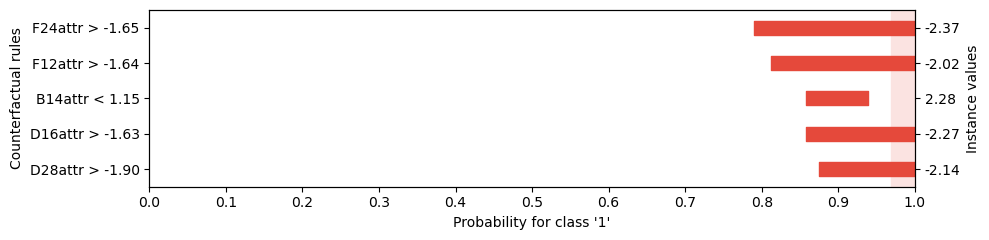

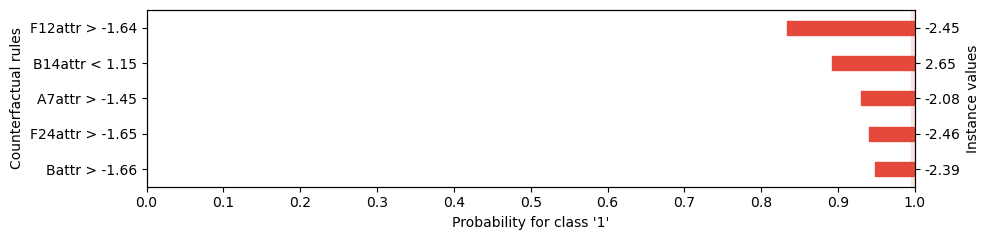

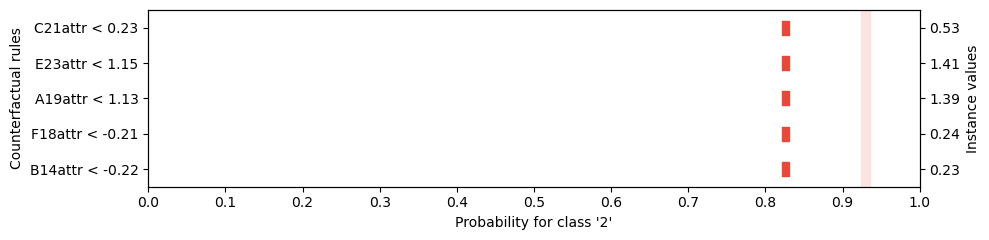

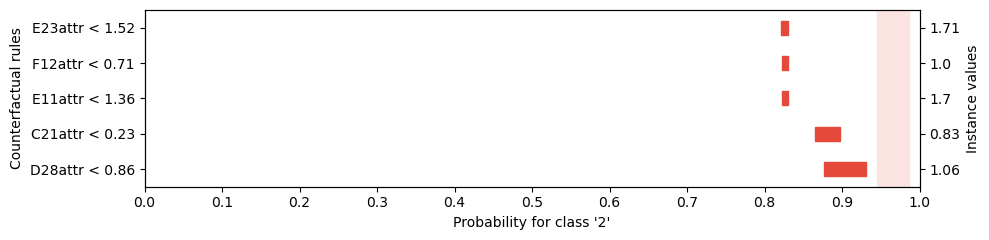

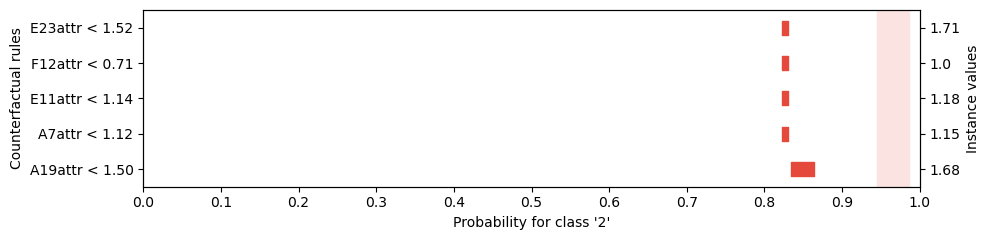

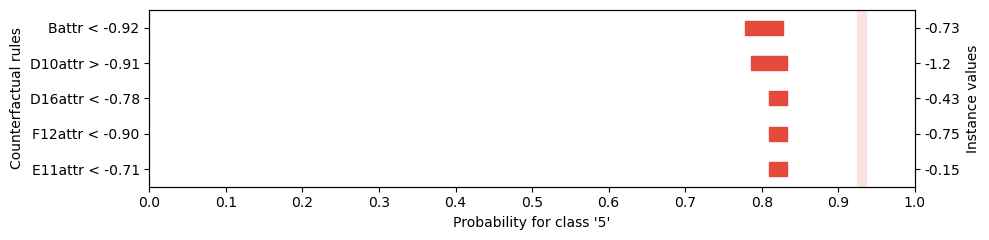

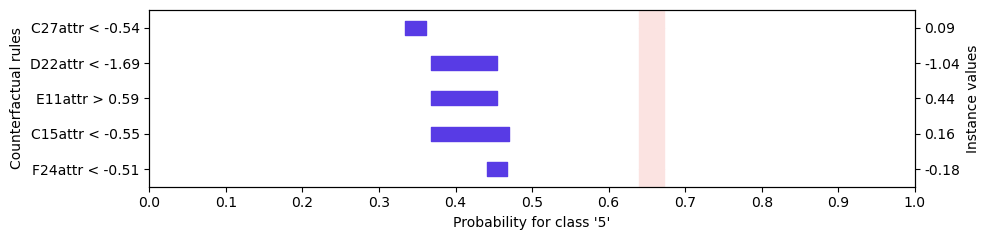

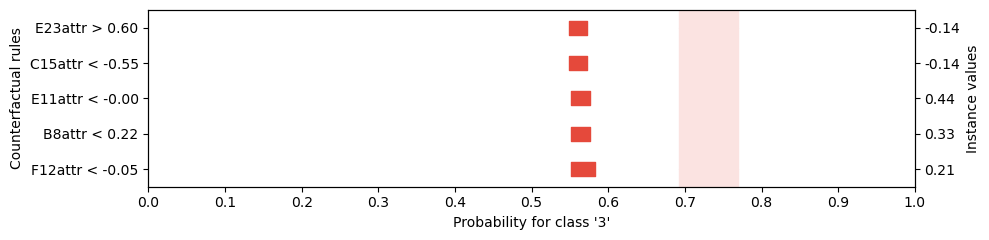

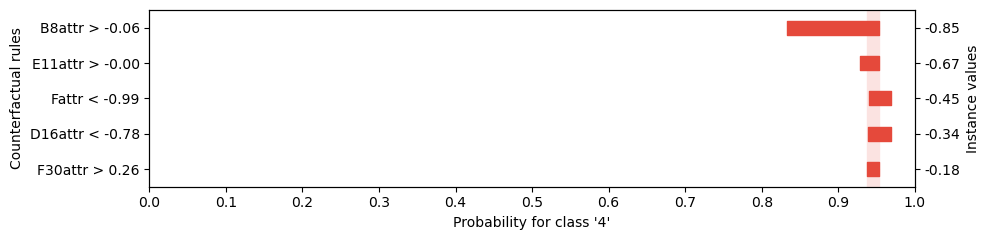

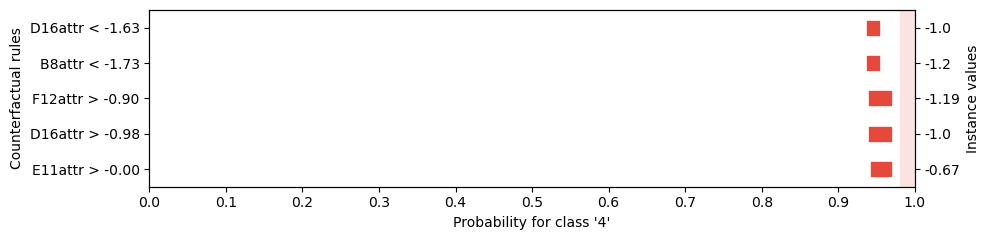

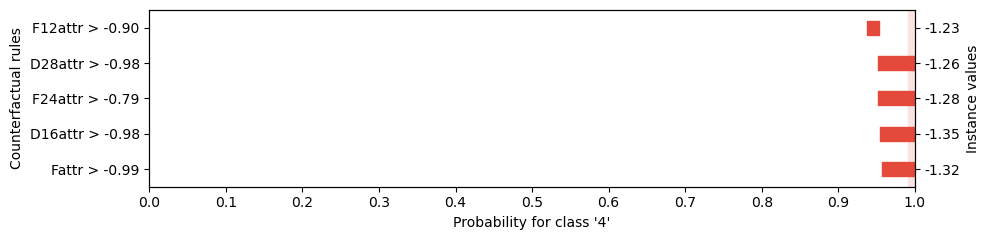

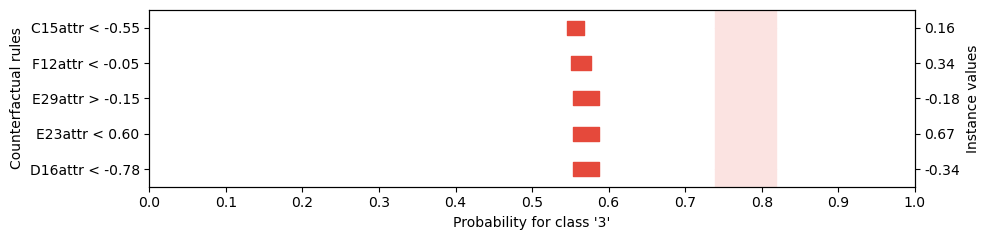

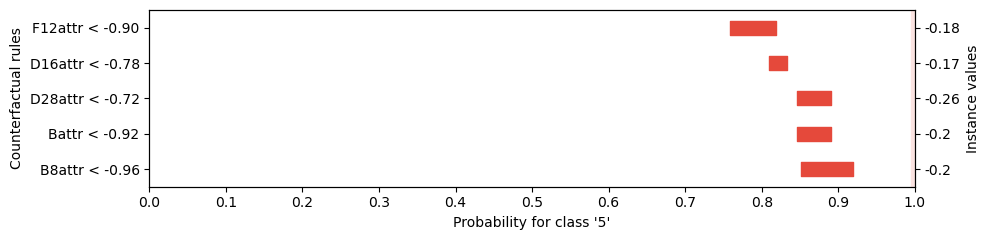

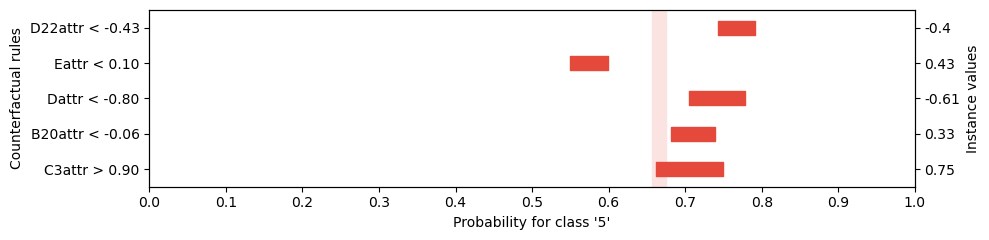

In [13]:
for i in range(num_to_test):
    counterfactual_explanation.plot_explanation(i, n_features_to_show=5)

Add conjunctions to one of the more difficult instances (actually belonging to class 5 but incorrectly predicted as class 3). Here, all the counterfactual conjunctive rules indicate that the prediction would have been something else if some features would have been different. Note that the explanations does not indicate what else the prediction would have been, only that it would not have been the predicted class. 

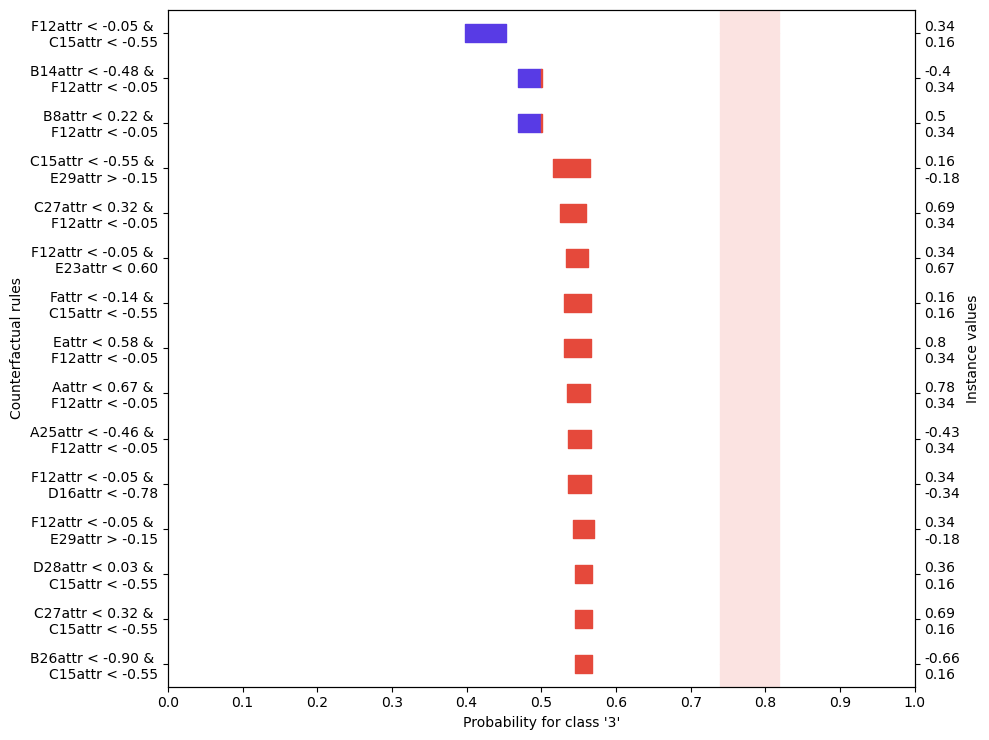

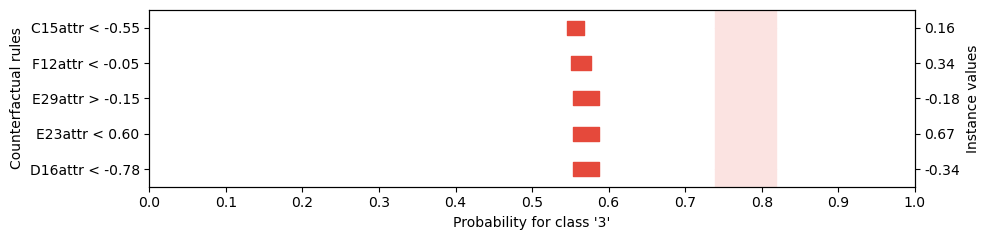

In [14]:
counterfactual_15 = counterfactual_explanation.get_explanation(15)
counterfactual_15.add_conjunctions(max_rule_size=2).plot_explanation(n_features_to_show=15)
counterfactual_15.remove_conjunctions().plot_explanation(n_features_to_show=5)

Another instance, being correctly predicted but with some uncertainty as to the prediction is shown with conjunctions below. Here, none of the conjunctions indicate that some other class might be more likely with slight alterations in the instance, similar to what the atomic rules indicate. 

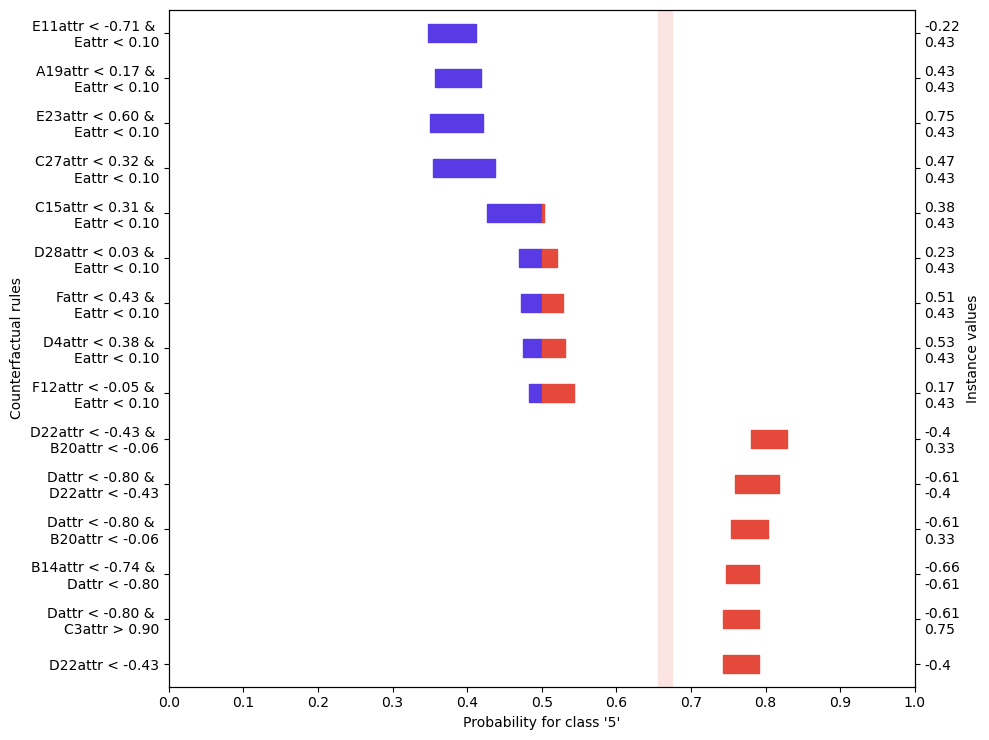

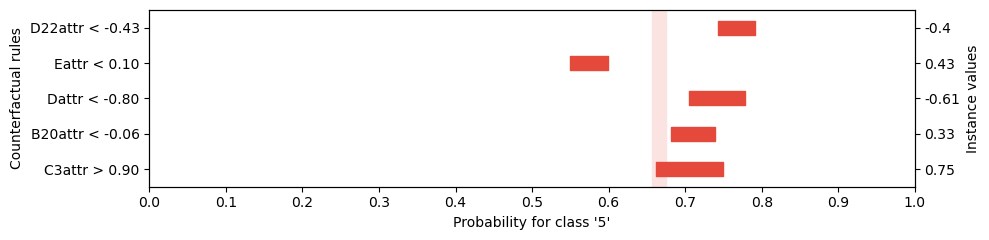

In [15]:
counterfactual_17 = counterfactual_explanation.get_explanation(17)
counterfactual_17.add_conjunctions(max_rule_size=3).plot_explanation(n_features_to_show=15)
counterfactual_17.remove_conjunctions().plot_explanation(n_features_to_show=5)